#### This implementation is beased upon two open sourced projects https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch and https://github.com/openai/improved-diffusion

### Provide the paths to the data folder, result storage folder, pretrained model path and pre-samples before running the file

In [9]:
data_folder_path = '/kaggle/input/gsoc-24-diffusion-task-data/Samples'
pretrained_model_path = '/kaggle/input/diffusion-pretrained/model-diffusion-10.pt'
result_folder_path = '/kaggle/working/results'
sample_dir = '/kaggle/input/sample-dir/Sample_dir'
presample_path = '/kaggle/input/presamples/pre-samples.pt' # contains the 2,500 samples used to calculate the FID score

In [10]:
# extract paths from the data directory
import os
import random
import numpy as np

def data_dir_to_path(my_dir_path):
    image_list = os.listdir(my_dir_path)
    path = []
    for i in range (0, len(image_list)):
        path.append(os.path.join(my_dir_path,image_list[i]))
        
    return path

image_path = data_dir_to_path(data_folder_path)

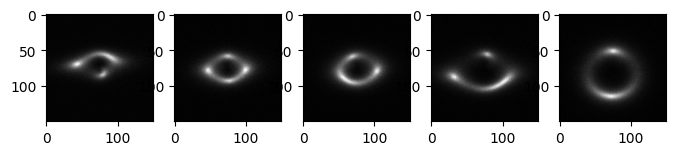

In [11]:
#visualizes few random images from the dataset
import matplotlib.pyplot as plt

fig, axs =  plt.subplots(1,5, figsize=(8,8))

for i in range(5):
    get_index = random.randrange(len(image_path))
#     print(get_index)
    img = np.load(image_path[get_index])
    axs[i].imshow(img[0,:,:], cmap='gray')

plt.show()

### Directly run cell below if running on kaggle or google colab, else install them independently

In [ ]:
!pip install einops
!pip install accelerate
!pip install ema-pytorch
!pip install torch_fidelity

### Flash Attention for faster training


In [13]:
from functools import wraps
from packaging import version
from collections import namedtuple

import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange

# constants

AttentionConfig = namedtuple('AttentionConfig', ['enable_flash', 'enable_math', 'enable_mem_efficient'])

# helpers

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def once(fn):
    called = False
    @wraps(fn)
    def inner(x):
        nonlocal called
        if called:
            return
        called = True
        return fn(x)
    return inner

print_once = once(print)

# main class

class Attend(nn.Module):
    def __init__(
        self,
        dropout = 0.,
        flash = False,
        scale = None
    ):
        super().__init__()
        self.dropout = dropout
        self.scale = scale
        self.attn_dropout = nn.Dropout(dropout)

        self.flash = flash
        assert not (flash and version.parse(torch.__version__) < version.parse('2.0.0')), 'in order to use flash attention, you must be using pytorch 2.0 or above'

        # determine efficient attention configs for cuda and cpu

        self.cpu_config = AttentionConfig(True, True, True)
        self.cuda_config = None

        if not torch.cuda.is_available() or not flash:
            return

        device_properties = torch.cuda.get_device_properties(torch.device('cuda'))

        if device_properties.major == 8 and device_properties.minor == 0:
            print_once('A100 GPU detected, using flash attention if input tensor is on cuda')
            self.cuda_config = AttentionConfig(True, False, False)
        else:
            print_once('Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda')
            self.cuda_config = AttentionConfig(False, True, True)

    def flash_attn(self, q, k, v):
        _, heads, q_len, _, k_len, is_cuda, device = *q.shape, k.shape[-2], q.is_cuda, q.device

        if exists(self.scale):
            default_scale = q.shape[-1]
            q = q * (scale / default_scale)

        q, k, v = map(lambda t: t.contiguous(), (q, k, v))

        # Check if there is a compatible device for flash attention

        config = self.cuda_config if is_cuda else self.cpu_config

        # pytorch 2.0 flash attn: q, k, v, mask, dropout, causal, softmax_scale

        with torch.backends.cuda.sdp_kernel(**config._asdict()):
            out = F.scaled_dot_product_attention(
                q, k, v,
                dropout_p = self.dropout if self.training else 0.
            )

        return out

    def forward(self, q, k, v):
        """
        einstein notation
        b - batch
        h - heads
        n, i, j - sequence length (base sequence length, source, target)
        d - feature dimension
        """

        q_len, k_len, device = q.shape[-2], k.shape[-2], q.device

        if self.flash:
            return self.flash_attn(q, k, v)

        scale = default(self.scale, q.shape[-1] ** -0.5)

        # similarity

        sim = einsum(f"b h i d, b h j d -> b h i j", q, k) * scale

        # attention

        attn = sim.softmax(dim = -1)
        attn = self.attn_dropout(attn)

        # aggregate values

        out = einsum(f"b h i j, b h j d -> b h i d", attn, v)

        return out

### U-Net Code

In [14]:
#complete U-Net code

import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

import torch
from torch.optim import Adam
from torchvision.transforms import transforms
from PIL import Image
from torch import nn, einsum
from torch.cuda.amp import autocast
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchvision import transforms as T, utils
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange
from tqdm.auto import tqdm
from ema_pytorch import EMA

from accelerate import Accelerator

# from denoising_diffusion_pytorch.attend import Attend
# from denoising_diffusion_pytorch.fid_evaluation import FIDEvaluation

# from denoising_diffusion_pytorch.version import __version__

# constants

ModelPrediction =  namedtuple('ModelPrediction', ['pred_noise', 'pred_x_start'])

# helpers functions

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def cast_tuple(t, length = 1):
    if isinstance(t, tuple):
        return t
    return ((t,) * length)

def divisible_by(numer, denom):
    return (numer % denom) == 0

def identity(t, *args, **kwargs):
    return t

def cycle(dl):
    while True:
        for data in dl:
            yield data

def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def convert_image_to_fn(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image

# normalization functions

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

# small helper modules

def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1 = 2, p2 = 2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1)
    )

class RMSNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        return F.normalize(x, dim = 1) * self.g * (x.shape[1] ** 0.5)

# sinusoidal positional embeds

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, theta = 10000):
        super().__init__()
        self.dim = dim
        self.theta = theta

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


# building block modules

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, groups = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):

        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)

class LinearAttention(nn.Module):
    def __init__(
        self,
        dim,
        heads = 4,
        dim_head = 32,
        num_mem_kv = 4
    ):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.norm = RMSNorm(dim)

        self.mem_kv = nn.Parameter(torch.randn(2, heads, dim_head, num_mem_kv))
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            RMSNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape

        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        mk, mv = map(lambda t: repeat(t, 'h c n -> b h c n', b = b), self.mem_kv)
        k, v = map(partial(torch.cat, dim = -1), ((mk, k), (mv, v)))

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)
        return self.to_out(out)

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        heads = 4,
        dim_head = 32,
        num_mem_kv = 4,
        flash = False
    ):
        super().__init__()
        self.heads = heads
        hidden_dim = dim_head * heads

        self.norm = RMSNorm(dim)
        self.attend = Attend(flash = flash)

        self.mem_kv = nn.Parameter(torch.randn(2, heads, num_mem_kv, dim_head))
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape

        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h (x y) c', h = self.heads), qkv)

        mk, mv = map(lambda t: repeat(t, 'h n d -> b h n d', b = b), self.mem_kv)
        k, v = map(partial(torch.cat, dim = -2), ((mk, k), (mv, v)))

        out = self.attend(q, k, v)

        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = h, y = w)
        return self.to_out(out)

# model

class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        out_dim = None,
        dim_mults = (1, 2, 4, 8),
        channels = 1,
        self_condition = False,
        resnet_block_groups = 8,
        learned_variance = False,
        learned_sinusoidal_cond = False,
        random_fourier_features = False,
        learned_sinusoidal_dim = 16,
        sinusoidal_pos_emb_theta = 10000,
        attn_dim_head = 32,
        attn_heads = 4,
        full_attn = None,    # defaults to full attention only for inner most layer
        flash_attn = False
    ):
        super().__init__()

        # determine dimensions

        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings

        time_dim = dim * 4

        sinu_pos_emb = SinusoidalPosEmb(dim, theta = sinusoidal_pos_emb_theta)
        fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # attention

        if not full_attn:
            full_attn = (*((False,) * (len(dim_mults) - 1)), True)

        num_stages = len(dim_mults)
        full_attn  = cast_tuple(full_attn, num_stages)
        attn_heads = cast_tuple(attn_heads, num_stages)
        attn_dim_head = cast_tuple(attn_dim_head, num_stages)

        assert len(full_attn) == len(dim_mults)

        FullAttention = partial(Attention, flash = flash_attn)

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, ((dim_in, dim_out), layer_full_attn, layer_attn_heads, layer_attn_dim_head) in enumerate(zip(in_out, full_attn, attn_heads, attn_dim_head)):
            is_last = ind >= (num_resolutions - 1)

            attn_klass = FullAttention if layer_full_attn else LinearAttention

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                attn_klass(dim_in, dim_head = layer_attn_dim_head, heads = layer_attn_heads),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        self.mid_attn = FullAttention(mid_dim, heads = attn_heads[-1], dim_head = attn_dim_head[-1])
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)

        for ind, ((dim_in, dim_out), layer_full_attn, layer_attn_heads, layer_attn_dim_head) in enumerate(zip(*map(reversed, (in_out, full_attn, attn_heads, attn_dim_head)))):
            is_last = ind == (len(in_out) - 1)

            attn_klass = FullAttention if layer_full_attn else LinearAttention

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                attn_klass(dim_out, dim_head = layer_attn_dim_head, heads = layer_attn_heads),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    @property
    def downsample_factor(self):
        return 2 ** (len(self.downs) - 1)

    def forward(self, x, time, x_self_cond = None):
        assert all([divisible_by(d, self.downsample_factor) for d in x.shape[-2:]]), f'your input dimensions {x.shape[-2:]} need to be divisible by {self.downsample_factor}, given the unet'

        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim = 1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x) + x
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x) + x
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t)
            x = attn(x) + x

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)



### DDPM process and functions

In [15]:
# gaussian diffusion trainer class

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


def sigmoid_beta_schedule(timesteps, start = -3, end = 3, tau = 1, clamp_min = 1e-5):
   
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype = torch.float64) / timesteps
    v_start = torch.tensor(start / tau).sigmoid()
    v_end = torch.tensor(end / tau).sigmoid()
    alphas_cumprod = (-((t * (end - start) + start) / tau).sigmoid() + v_end) / (v_end - v_start)
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        model,
        *,
        image_size,
        timesteps = 1000,
        sampling_timesteps = None,
        objective = 'pred_x0',
        beta_schedule = 'sigmoid',
        schedule_fn_kwargs = dict(),
        ddim_sampling_eta = 0.,
        auto_normalize = True,
        offset_noise_strength = 0.,  # https://www.crosslabs.org/blog/diffusion-with-offset-noise
        min_snr_loss_weight = False, # https://arxiv.org/abs/2303.09556
        min_snr_gamma = 5
    ):
        super().__init__()
        assert not (type(self) == GaussianDiffusion and model.channels != model.out_dim)
        assert not hasattr(model, 'random_or_learned_sinusoidal_cond') or not model.random_or_learned_sinusoidal_cond

        self.model = model

        self.channels = self.model.channels
        self.self_condition = self.model.self_condition

        self.image_size = image_size

        self.objective = objective

        assert objective in {'pred_noise', 'pred_x0', 'pred_v'}, 'objective must be either pred_noise (predict noise) or pred_x0 (predict image start) or pred_v (predict v [v-parameterization as defined in appendix D of progressive distillation paper, used in imagen-video successfully])'

        betas = sigmoid_beta_schedule(timesteps, **schedule_fn_kwargs)

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.)

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)

        # sampling related parameters

        self.sampling_timesteps = default(sampling_timesteps, timesteps) # default num sampling timesteps to number of timesteps at training

        assert self.sampling_timesteps <= timesteps
        self.is_ddim_sampling = self.sampling_timesteps < timesteps
        self.ddim_sampling_eta = ddim_sampling_eta

        # helper function to register buffer from float64 to float32

        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))

        register_buffer('betas', betas)
        register_buffer('alphas_cumprod', alphas_cumprod)
        register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)

        # calculations for diffusion q(x_t | x_{t-1}) and others

        register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - alphas_cumprod))
        register_buffer('log_one_minus_alphas_cumprod', torch.log(1. - alphas_cumprod))
        register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_cumprod))
        register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_cumprod - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)

        posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)

        register_buffer('posterior_variance', posterior_variance)

        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain

        register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min =1e-20)))
        register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
        register_buffer('posterior_mean_coef2', (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod))

        # offset noise strength - in blogpost, they claimed 0.1 was ideal

        self.offset_noise_strength = offset_noise_strength

        # derive loss weight
        # snr - signal noise ratio

        snr = alphas_cumprod / (1 - alphas_cumprod)

        # https://arxiv.org/abs/2303.09556

        maybe_clipped_snr = snr.clone()
        if min_snr_loss_weight:
            maybe_clipped_snr.clamp_(max = min_snr_gamma)

        if objective == 'pred_noise':
            register_buffer('loss_weight', maybe_clipped_snr / snr)
        elif objective == 'pred_x0':
            register_buffer('loss_weight', maybe_clipped_snr)
        elif objective == 'pred_v':
            register_buffer('loss_weight', maybe_clipped_snr / (snr + 1))

        # auto-normalization of data [0, 1] -> [-1, 1] - can turn off by setting it to be False

        self.normalize = normalize_to_neg_one_to_one if auto_normalize else identity
        self.unnormalize = unnormalize_to_zero_to_one if auto_normalize else identity

    @property
    def device(self):
        return self.betas.device

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def predict_noise_from_start(self, x_t, t, x0):
        return (
            (extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - x0) / \
            extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)
        )

    def predict_v(self, x_start, t, noise):
        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * noise -
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * x_start
        )

    def predict_start_from_v(self, x_t, t, v):
        return (
            extract(self.sqrt_alphas_cumprod, t, x_t.shape) * x_t -
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape) * v
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def model_predictions(self, x, t, x_self_cond = None, clip_x_start = False, rederive_pred_noise = False):
        model_output = self.model(x, t, x_self_cond)
        maybe_clip = partial(torch.clamp, min = -1., max = 1.) if clip_x_start else identity

        if self.objective == 'pred_noise':
            pred_noise = model_output
            x_start = self.predict_start_from_noise(x, t, pred_noise)
            x_start = maybe_clip(x_start)

            if clip_x_start and rederive_pred_noise:
                pred_noise = self.predict_noise_from_start(x, t, x_start)

        elif self.objective == 'pred_x0':
            x_start = model_output
            x_start = maybe_clip(x_start)
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        elif self.objective == 'pred_v':
            v = model_output
            x_start = self.predict_start_from_v(x, t, v)
            x_start = maybe_clip(x_start)
            pred_noise = self.predict_noise_from_start(x, t, x_start)

        return ModelPrediction(pred_noise, x_start)

    def p_mean_variance(self, x, t, x_self_cond = None, clip_denoised = True):
        preds = self.model_predictions(x, t, x_self_cond)
        x_start = preds.pred_x_start

        if clip_denoised:
            x_start.clamp_(-1., 1.)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start = x_start, x_t = x, t = t)
        return model_mean, posterior_variance, posterior_log_variance, x_start


    @torch.inference_mode()
    def ddim_sample(self, shape, return_all_timesteps = False):
        batch, device, total_timesteps, sampling_timesteps, eta, objective = shape[0], self.device, self.num_timesteps, self.sampling_timesteps, self.ddim_sampling_eta, self.objective

        times = torch.linspace(-1, total_timesteps - 1, steps = sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
        times = list(reversed(times.int().tolist()))
        time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

        img = torch.randn(shape, device = device)
        imgs = [img]

        x_start = None

        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
            time_cond = torch.full((batch,), time, device = device, dtype = torch.long)
            self_cond = x_start if self.self_condition else None
            pred_noise, x_start, *_ = self.model_predictions(img, time_cond, self_cond, clip_x_start = True, rederive_pred_noise = True)

            if time_next < 0:
                img = x_start
                imgs.append(img)
                continue

            alpha = self.alphas_cumprod[time]
            alpha_next = self.alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(img)

            img = x_start * alpha_next.sqrt() + \
                  c * pred_noise + \
                  sigma * noise

            imgs.append(img)

        ret = img if not return_all_timesteps else torch.stack(imgs, dim = 1)

        ret = self.unnormalize(ret)
        return ret

    @torch.inference_mode()
    def sample(self, batch_size = 16, return_all_timesteps = False):
        image_size, channels = self.image_size, self.channels
        return self.ddim_sample((batch_size, channels, image_size, image_size), return_all_timesteps = return_all_timesteps)


    @autocast(enabled = False)
    def q_sample(self, x_start, t, noise = None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    def p_losses(self, x_start, t, noise = None, offset_noise_strength = None):
        b, c, h, w = x_start.shape

        noise = default(noise, lambda: torch.randn_like(x_start))

        # offset noise - https://www.crosslabs.org/blog/diffusion-with-offset-noise

        offset_noise_strength = default(offset_noise_strength, self.offset_noise_strength)

        if offset_noise_strength > 0.:
            offset_noise = torch.randn(x_start.shape[:2], device = self.device)
            noise += offset_noise_strength * rearrange(offset_noise, 'b c -> b c 1 1')

        # noise sample

        x = self.q_sample(x_start = x_start, t = t, noise = noise)

        x_self_cond = None
        if self.self_condition and random() < 0.5:
            with torch.no_grad():
                x_self_cond = self.model_predictions(x, t).pred_x_start
                x_self_cond.detach_()

        # predict and take gradient step

        model_out = self.model(x, t, x_self_cond)

        if self.objective == 'pred_noise':
            target = noise
        elif self.objective == 'pred_x0':
            target = x_start
        elif self.objective == 'pred_v':
            v = self.predict_v(x_start, t, noise)
            target = v
        else:
            raise ValueError(f'unknown objective {self.objective}')

        loss = F.mse_loss(model_out, target, reduction = 'none')
        loss = reduce(loss, 'b ... -> b', 'mean')

        loss = loss * extract(self.loss_weight, t, loss.shape)
        return loss.mean()

    def forward(self, img, *args, **kwargs):
        b, c, h, w, device, img_size, = *img.shape, img.device, self.image_size
        assert h == img_size and w == img_size, f'height and width of image must be {img_size}'
        t = torch.randint(0, self.num_timesteps, (b,), device=device).long()

        img = self.normalize(img)
        return self.p_losses(img, t, *args, **kwargs)


In [16]:
# dataset class

class Dataset(Dataset):
    def __init__(self, image_paths):
        super().__init__()
        self.image_paths = image_paths
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = np.load(image_filepath)
        image = image.reshape(150 ,150)
        image = Image.fromarray(np.uint8((image)*255), 'L')
        
        
        transform = transforms.Compose([
            transforms.CenterCrop(128),
            transforms.ToTensor(),
        ])
        
        image = transform(image)
        return image
    

### Main trainer Class

In [17]:
# trainer class

class Trainer(object):
    def __init__(
        self,
        diffusion_model,
        folder,
        *,
        train_batch_size = 16,
        gradient_accumulate_every = 1,
        augment_horizontal_flip = True,
        train_lr = 1e-4,
        train_num_steps = 100000,
        ema_update_every = 10,
        ema_decay = 0.995,
        adam_betas = (0.9, 0.99),
        save_and_sample_every = 10000,
        num_samples = 16,
        results_folder = result_folder_path,
        amp = False,
        mixed_precision_type = 'fp16',
        split_batches = True,
        convert_image_to = None,
        max_grad_norm = 1.,
    ):
        super().__init__()

        # accelerator

        self.accelerator = Accelerator(
            split_batches = split_batches,
            mixed_precision = mixed_precision_type if amp else 'no'
        )

        # model

        self.model = diffusion_model
        self.channels = diffusion_model.channels
        is_ddim_sampling = diffusion_model.is_ddim_sampling

        # default convert_image_to depending on channels

        if not exists(convert_image_to):
            convert_image_to = {1: 'L', 3: 'RGB', 4: 'RGBA'}.get(self.channels)

        # sampling and training hyperparameters

        assert has_int_squareroot(num_samples), 'number of samples must have an integer square root'
        self.num_samples = num_samples
        self.save_and_sample_every = save_and_sample_every

        self.batch_size = train_batch_size
        self.gradient_accumulate_every = gradient_accumulate_every
        assert (train_batch_size * gradient_accumulate_every) >= 16, f'your effective batch size (train_batch_size x gradient_accumulate_every) should be at least 16 or above'

        self.train_num_steps = train_num_steps
        self.image_size = diffusion_model.image_size

        self.max_grad_norm = max_grad_norm

        # dataset and dataloader

        self.ds = Dataset(image_path)

        assert len(self.ds) >= 100, 'you should have at least 100 images in your folder. at least 10k images recommended'

        dl = DataLoader(self.ds, batch_size = train_batch_size, shuffle = True, pin_memory = True, num_workers = cpu_count())

        dl = self.accelerator.prepare(dl)
        self.dl = cycle(dl)

        # optimizer

        self.opt = Adam(diffusion_model.parameters(), lr = train_lr, betas = adam_betas)

        # for logging results in a folder periodically

        if self.accelerator.is_main_process:
            self.ema = EMA(diffusion_model, beta = ema_decay, update_every = ema_update_every)
            self.ema.to(self.device)

        self.results_folder = Path(results_folder)
        self.results_folder.mkdir(exist_ok = True)

        # step counter state

        self.step = 0

        # prepare model, dataloader, optimizer with accelerator

        self.model, self.opt = self.accelerator.prepare(self.model, self.opt)



    @property
    def device(self):
        return self.accelerator.device

    def save(self, milestone):
        if not self.accelerator.is_local_main_process:
            return

        data = {
            'step': self.step,
            'model': self.accelerator.get_state_dict(self.model),
            'opt': self.opt.state_dict(),
            'ema': self.ema.state_dict(),
            'scaler': self.accelerator.scaler.state_dict() if exists(self.accelerator.scaler) else None,
#             'version': __version__
        }

        torch.save(data, str(self.results_folder / f'model-{milestone}.pt'))

    def load(self, path):
        accelerator = self.accelerator
        device = accelerator.device

#         data = torch.load(str(self.results_folder / f'model-{milestone}.pt'), map_location=device)
        data = torch.load(path, map_location=device)

        model = self.accelerator.unwrap_model(self.model)
        model.load_state_dict(data['model'])

        self.step = data['step']
        self.opt.load_state_dict(data['opt'])
        if self.accelerator.is_main_process:
            self.ema.load_state_dict(data["ema"])

        if 'version' in data:
            print(f"loading from version {data['version']}")

        if exists(self.accelerator.scaler) and exists(data['scaler']):
            self.accelerator.scaler.load_state_dict(data['scaler'])

    def train(self):
        accelerator = self.accelerator
        device = accelerator.device

        with tqdm(initial = self.step, total = self.train_num_steps, disable = not accelerator.is_main_process) as pbar:

            while self.step < self.train_num_steps:

                total_loss = 0.

                for _ in range(self.gradient_accumulate_every):
                    data = next(self.dl).to(device)

                    with self.accelerator.autocast():
                        loss = self.model(data)
                        loss = loss / self.gradient_accumulate_every
                        total_loss += loss.item()

                    self.accelerator.backward(loss)

                pbar.set_description(f'loss: {total_loss:.4f}')

                accelerator.wait_for_everyone()
                accelerator.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)

                self.opt.step()
                self.opt.zero_grad()

                accelerator.wait_for_everyone()

                self.step += 1
                if accelerator.is_main_process:
                    self.ema.update()

                    if self.step != 0 and divisible_by(self.step, self.save_and_sample_every):
                        self.ema.ema_model.eval()

                        with torch.inference_mode():
                            milestone = self.step // self.save_and_sample_every
                            batches = num_to_groups(self.num_samples, self.batch_size)
                            all_images_list = list(map(lambda n: self.ema.ema_model.sample(batch_size=n), batches))

                        all_images = torch.cat(all_images_list, dim = 0)

                        utils.save_image(all_images, str(self.results_folder / f'sample-{milestone}.png'), nrow = int(math.sqrt(self.num_samples)))
                        self.save(milestone)

                pbar.update(1)

        accelerator.print('training complete')

### Model Initializations

In [18]:
#create model and trainer instances

model = Unet(
    dim = 32,
    dim_mults = (1, 2, 2, 4),
    flash_attn = True
)

diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000,           # number of steps
    sampling_timesteps = 1000    # number of sampling timesteps (using ddim for faster inference [see citation for ddim paper])
)

trainer = Trainer(
    diffusion,
    '/kaggle/input/gsoc-24-diffusion-task-data/Samples',
    train_batch_size = 16,
    train_lr = 8e-5,
    train_num_steps = 100000,         # total training steps
    
    gradient_accumulate_every = 1,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = True,                       # turn on mixed precision
)


Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


### Run only if a model is to trained from scratch

In [ ]:
trainer.train()

### Run this cell if pretrained model is to be loaded for sampling 

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

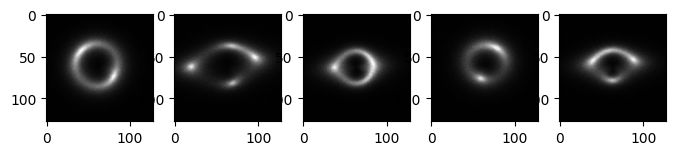

In [19]:
trainer.load(pretrained_model_path)
sampled_images = trainer.ema.ema_model.sample(batch_size=5)

fig, axs =  plt.subplots(1,5, figsize=(8,8))

for i in range(5):
    img = sampled_images[i].cpu().detach().numpy()
    img = np.transpose(img, (1,2,0))
    axs[i].imshow(img, cmap='gray')



### Run if FID is to be calculated (the function needs a model.pth file and pre-sample.pt file (only if pre generated samples are to be used, else mention None) if no changes are made the function will calculate FID on the pretrained model. Please provide the number of  samples on which FID is to be calculated in multiple of 100.)

In [23]:
from torchmetrics.image.fid import FrechetInceptionDistance
import torch_fidelity
import torch
from PIL import Image

sampled_images = None

def calculate_fid(pretrained_model_path, presample_path, num_samples):
    
    dataset = Dataset(image_path)
    dl = DataLoader(dataset, batch_size = num_samples, shuffle = True, pin_memory = True, num_workers = cpu_count())
    iterator = iter(dl)
    real_images = next(iterator)
    
    if not presample_path == None:
        sampled_images = torch.load(presample_path)
            
    else:
        trainer.load(pretrained_model_path)
        
        # generate samples
        sampled_images = trainer.ema.ema_model.sample(batch_size=100)
        for i in range(int(num_samples / 100) - 1):
            temp_sample_images = trainer.ema.ema_model.sample(batch_size=100)
            sampled_images = torch.concat((sampled_images, temp_sample_images), dim=0)
    
    save_sample = sampled_images
    sampled_images = sampled_images * 255
    sampled_images = sampled_images.to('cuda')
    sampled_images = sampled_images.to(torch.uint8)
    sampled_images = sampled_images.repeat(1, 3, 1, 1)
    
    real_images = real_images.to('cuda')
    real_images = real_images * 255
    real_images = real_images.to(torch.uint8)
    real_images = real_images.repeat(1, 3, 1, 1)
    
    fid = FrechetInceptionDistance(feature=2048, normalize=False)
    fid.to('cuda')
    
    for i in range(num_samples // 100):
        fid.update(real_images[100*i:100*(i+1)], real=True)
        fid.update(sampled_images[100*i:100*(i+1)], real=False)
        
    fid_score = fid.compute()
    return fid_score, x

fid, save_sample = calculate_fid(pretrained_model_path, presample_path, 2500)
print(f'The FID value is {fid.item()}')

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 279MB/s]


The FID value is 3.586735486984253
